In [1]:
import os
import sys
from os import path

In [2]:
import json
from pycocotools import coco
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon,Rectangle
from matplotlib.collections import PatchCollection
from PIL import Image

In [3]:
data_path = '/data/leavesboxes1image/'


In [4]:
img = Image.open(path.join(data_path,'20200307_160518.jpg'))

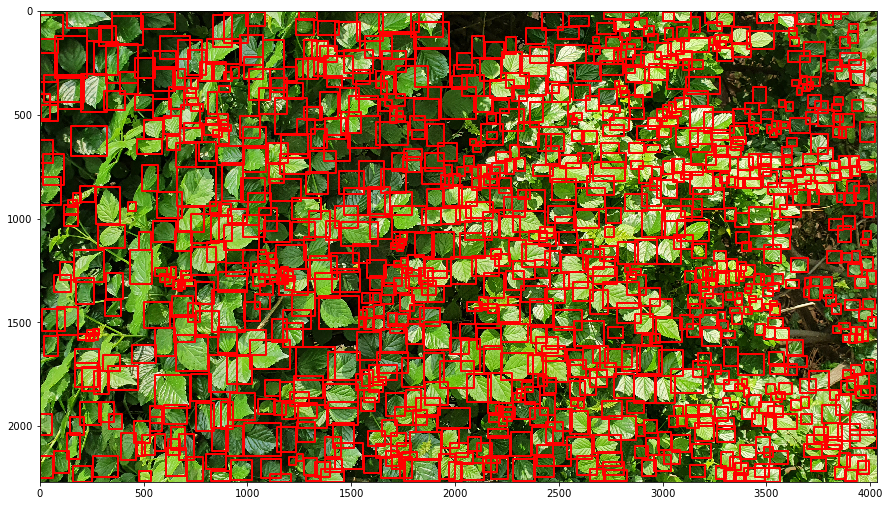

In [186]:
f,ax = plt.subplots(1,1,figsize=(15,15))
ax.imshow(img)
polygons = []
color = []

for ann in c_data.loadAnns(ids=ids):
    c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
    if 'segmentation' in ann:
        if type(ann['segmentation']) == list:
            # polygon
            seg = ann['segmentation']
            poly = np.array(seg).reshape((int(len(seg)/2), 2))
            polygons.append(Polygon(poly))
            color.append(c)
p = PatchCollection(polygons, facecolor='none', edgecolors='r', linewidths=2)
ax.add_collection(p);

In [5]:
img.width

4032

In [6]:
test_frac=.25
val_frac=.15

width = img.width
height = img.height
test_split = int(width*(1-test_frac))
val_split = int(test_split*(1-val_frac))
test_box = [test_split,0,width,height]
val_box = [val_split,0,test_split,height]
train_box = [0,0,val_split,height]

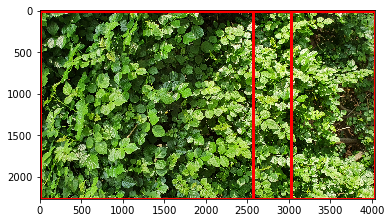

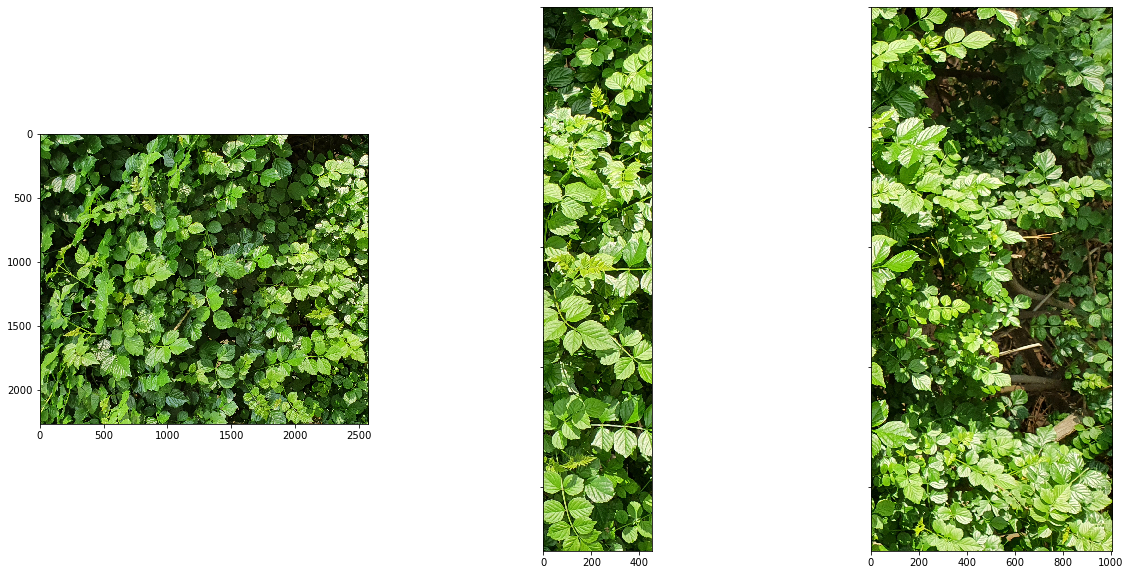

In [7]:
p = []
for box in [test_box,val_box,train_box]:
    p.append(Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],
                  linewidth=1,edgecolor='r',facecolor='none'))
train_img = img.crop(train_box)
val_img = img.crop(val_box)
test_img = img.crop(test_box)
fig,ax = plt.subplots(1)
ax.imshow(img)
ax.add_collection(PatchCollection(p,linewidth=3,edgecolor='r',facecolor='none'))

f, ax = plt.subplots(1,3,figsize = (20,10),sharey=True)
ax[0].imshow(train_img)
ax[1].imshow(val_img)
ax[2].imshow(test_img)

In [8]:
with open(path.join(data_path,'via_export_coco.json'),'r') as f:
    annotations = json.loads(f.read())
for ann in annotations['annotations']:
    ann['category_id'] = 'leaf'
with open(path.join(data_path,'via_export_coco_cat.json'),'w') as f:
    f.write(json.dumps(annotations))

In [100]:
print(json.dumps(annotations,indent=4))

{
    "info": {
        "year": 2020,
        "version": "1",
        "description": "Exported using VGG Image Annotator (http://www.robots.ox.ac.uk/~vgg/software/via/)",
        "contributor": "",
        "url": "http://www.robots.ox.ac.uk/~vgg/software/via/",
        "date_created": "Fri Apr 10 2020 15:25:20 GMT+0300 (Israel Daylight Time)"
    },
    "images": [
        {
            "id": 0,
            "width": 4032,
            "height": 2268,
            "file_name": "20200307_160518.jpg",
            "license": 1,
            "date_captured": ""
        }
    ],
    "annotations": [
        {
            "id": 0,
            "image_id": "0",
            "segmentation": [
                200,
                303,
                324,
                303,
                324,
                484,
                200,
                484
            ],
            "area": 22444,
            "bbox": [
                200,
                303,
                124,
                18

In [157]:
bboxes = []
ids = []
for ann in annotations['annotations']:
    x_min = ann['bbox'][0]
    y_min = ann['bbox'][1]
    x_max = ann['bbox'][0]+ann['bbox'][2] 
    y_max = ann['bbox'][1]+ann['bbox'][3]
    bboxes.append([x_min,y_min,x_max,y_max])
    ids.append(ann['id'])

In [158]:
def get_boxes_inside_box(big_box, boxes,boxes_ids, min_overlap=0.5):
    """
    get all the bboxes that have more than min_overlap part of their area inside big_box
    box := [x_min,y_min,x_max,y_max]
    """
    inside_bboxes = []
    ids = []
    for bbox,idx in zip(bboxes,boxes_ids):
        x_min = max(bbox[0],big_box[0])
        y_min = max(bbox[1],big_box[1])
        x_max = min(bbox[2],big_box[2])
        y_max = min(bbox[3],big_box[3])
        if x_max-x_min > 0 and y_max-y_min > 0:
            bbox_area = (bbox[0]-bbox[2])*(bbox[1]-bbox[3])
            if (x_max-x_min)*(y_max-y_min) > min_overlap * bbox_area:
                inside_bboxes.append([x_min,y_min,x_max,y_max])
                ids.append(idx)
    return inside_bboxes,ids

In [160]:
test_bboxes, test_ids = get_boxes_inside_box(test_box,bboxes,ids,0.3)
val_bboxes, val_ids = get_boxes_inside_box(val_box,bboxes,ids,0.3)
train_bboxes, train_ids = get_boxes_inside_box(train_box,bboxes,ids,0.3)

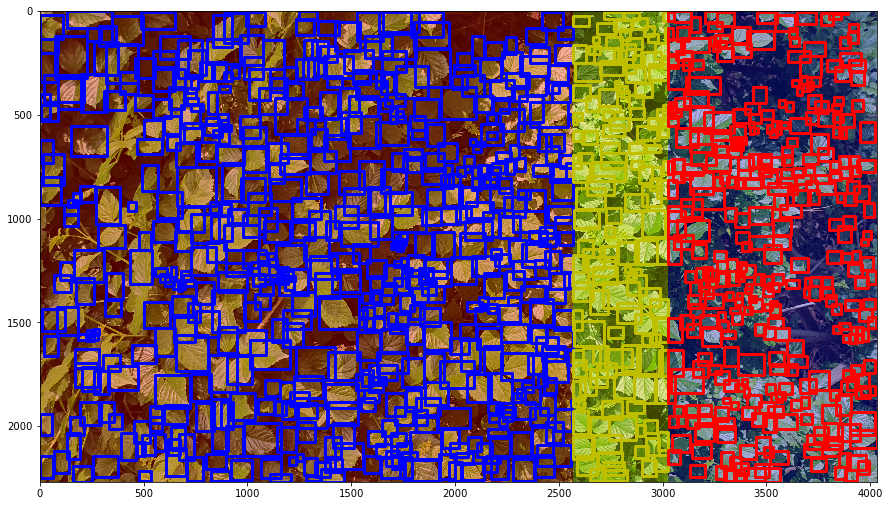

In [164]:
f,ax = plt.subplots(1,1,figsize=(15,15))
ax.imshow(img)
polygons = []
color = []
p=[]
for box in [test_box,val_box,train_box]:
    p.append(Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],
                  linewidth=1,edgecolor='r',facecolor='none'))
ax.add_collection(PatchCollection(p,linewidth=3,edgecolor='none',facecolor=['b','y','r'], alpha=0.3))

p=[]
for box in train_bboxes:
    p.append(Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1]))
ax.add_collection(PatchCollection(p,linewidth=3,edgecolor='b',facecolor='none'))

p=[]
for box in val_bboxes:
    p.append(Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1]))
ax.add_collection(PatchCollection(p,linewidth=3,edgecolor='y',facecolor='none'))

p=[]
for box in test_bboxes:
    p.append(Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1]))
ax.add_collection(PatchCollection(p,linewidth=3,edgecolor='r',facecolor='none'))

In [13]:
!python my_dataset.py

Figure(1000x1000)


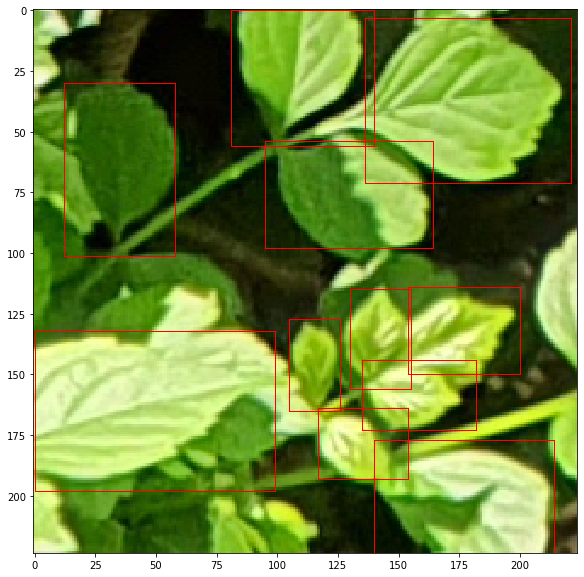

In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from my_dataset import CropDataset
from os import path

data_path = '/data/leavesboxes1image/'

annotatio_path = path.join(data_path,'via_export_coco_cat.json')

image_path = path.join(data_path,'20200307_160518.jpg')

my_dataset = CropDataset(image_path,annotatio_path,dataset='test')

test_crop, ann = my_dataset[1]
f,ax = plt.subplots(1,1,figsize=(10,10))

plt.imshow(test_crop)
p=[]
for box in ann['boxes']:
    p.append(Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1]))
    ax.add_collection(PatchCollection(p,linewidth=1,edgecolor='r',facecolor='none'))

In [276]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


In [277]:
model = get_model(2)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/user/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [01:03<00:00, 2.65MB/s] 


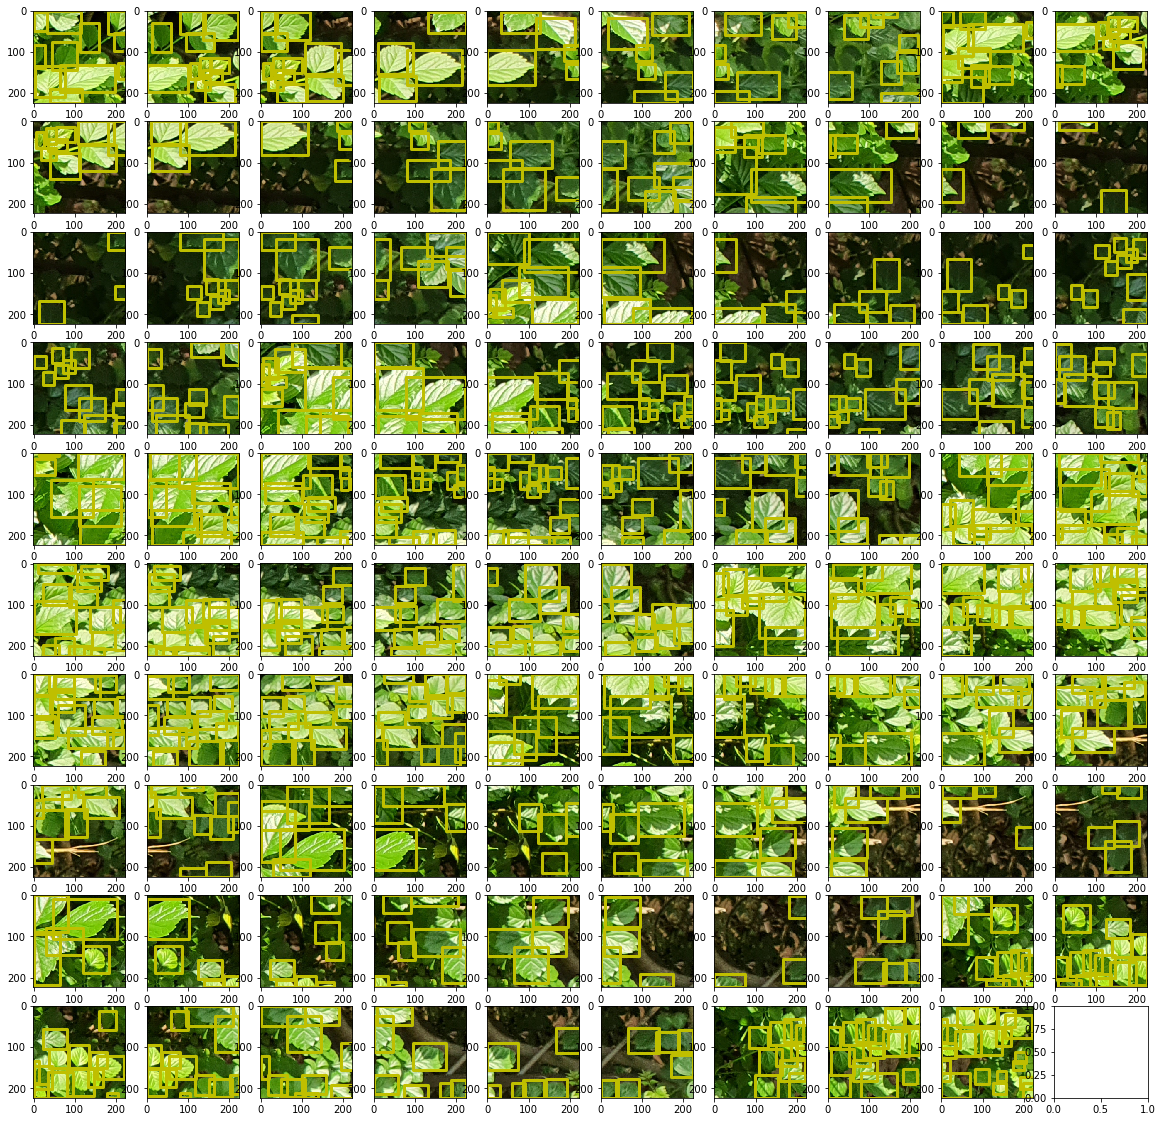

In [184]:
set_box = test_box

f, ax = plt.subplots(10,10,figsize=(20,20))
ax = ax.ravel()
crop_size=224
stride = 100
n_width = int((set_box[2]-set_box[0] - crop_size) / stride + 1)
n_height = int((set_box[3]-set_box[1]  - crop_size) / stride + 1)
crops = []
crop_tags = []
crop_tags_ids = []
i_ax=0
for j in range(n_height):
    for i in range(n_width):
        crop_box = [i * stride + set_box[0], j * stride + set_box[1], i * stride + crop_size + set_box[0], j * stride + crop_size + set_box[1]]
        crop_img = img.crop(crop_box)
        crops.append(crop_img)
        ct_temp,ti_temp = get_boxes_inside_box(crop_box,bboxes,ids,0.3)
        p=[]
        for box in ct_temp:
            box = [box[0]-crop_box[0],box[1]-crop_box[1],box[2]-crop_box[0],box[3]-crop_box[1]]
            p.append(Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1]))
        crop_tags_ids.append(ti_temp)
        crop_tags.append(ct_temp)
        ax[i_ax].imshow(crop_img)
        ax[i_ax].add_collection(PatchCollection(p,linewidth=3,edgecolor='y',facecolor='none'))
        i_ax += 1
        if i_ax >= len(ax)-1:
            break
    if i_ax >= len(ax)-1:
        break
f.show()

In [174]:
box

[138, 12, 177, 43]

In [102]:
for ann in annotations['annotations'][0:2]:
    print(np.array(ann['segmentation']).reshape(-1,2))

[[200 303]
 [324 303]
 [324 484]
 [200 484]]
[[ 90 312]
 [207 312]
 [207 473]
 [ 90 473]]


In [106]:
ann['bbox']

[90, 312, 117, 161]

In [107]:
x_min = ann['bbox'][0]
y_min = ann['bbox'][1]
x_max = ann['bbox'][0]+ann['bbox'][2] 
y_max = ann['bbox'][1]+ann['bbox'][3]

In [109]:
print([x_min,y_min,x_max,y_max])

[90, 312, 207, 473]


In [27]:
annotations['annotations'][0]['category_id']='leaf'

In [28]:
annotations['annotations'][0]

{'id': 0,
 'image_id': '0',
 'segmentation': [200, 303, 324, 303, 324, 484, 200, 484],
 'area': 22444,
 'bbox': [200, 303, 124, 181],
 'iscrowd': 0,
 'category_id': 'leaf'}

In [17]:
c_data.download()

{}

In [3]:

imgs = os.listdir(imgs_path)
imgs = [img for img in imgs if '.jpg' in img]